### 零、首先安装依赖

In [ ]:
!pip install spacy  # 用于分词
!python -m spacy download en_core_web_sm  # 下载分词词库
!pip install rouge  # 用于计算Rouge-l指标
!pip install nltk  # 用于计算bleu指标
!pip install torch torchvision
!pip install tqdm  # 用于实现进度条
!pip install matplotlib  # 用来实现可视化
!pip install tensorboard  # 用来记录训练过程

### 一、导入模块

由于数据集、词表、评估标准当中在两个实验中有很多共用的地方，故编写在`datasets.py`,`vocabualary.py`和`metrics.py`中，不在notebook中体现。
- datasets.py: `ImageTextDataset`类
    - 使用了懒加载和缓存策略
- vocabulary.py：`Vocabulary`类，
    - 实现了从语料构建词表的`build`工厂方法，可以将构建好的词表保存为json文件。
    - 在构造函数`__init__`中传入词表json文件路径即可完成构造。
    - vocabulary实现了基础的词表查询，倒排索引，从文本编码为序列`encode`方法，和从序列解码为文本`decode`方法, 填充序列`pad_sequence`方法
    - 实现了获取spacy提供的词表的96维预训练权重`get_word2vec`方法
    - 实现了`split`分词方法
- metrics.py: 
    - 实现了`bleu`, `rouge-l`, `meteor`评估标准

In [1]:
import math
import os
from functools import partial
from typing import List, Tuple

import matplotlib
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

from tqdm import tqdm
from datetime import datetime, timedelta

from datasets import ImageTextDataset
from vocabulary import Vocabulary
from metrics import bleu, meteor, rouge_l

### 二、定义模型

实现了ViT编码器架构和Transformer解码器架构。
ViT将图像分割为若干个相同大小的patch，每一个patch应用卷积获取单片的特征向量，然后将所有片的特征向量展平成为序列，作为ViT Encoder输入。
ViT编码器使用了经典的Transformer编码器架构，使用了多个编码器层，每个层使用了带有残差连接的多头自注意力和点对点前馈层，使用了随机位置编码给图像添加位置信息
Transformer解码器使用了经典的Transformer解码器架构，使用了多个解码器层，进入解码器的序列首先进行正余弦位置编码，每个解码器层包含了多头自注意力和多头跨模态交叉注意力，自注意力使用了三角掩码与pad掩码，然后接着点对点前馈层。最后一个解码器层的输出序列经过一个全连接层得到分类输出，总类别数是词表大小。
最后一个解码器层的交叉注意力权重被保留，reshape到原始图像尺寸，可视化为注意力热图

In [15]:
class PatchEmbedding(nn.Module):
    """ViT嵌入层，通过将原始图像分为若干个小块，分别嵌入，然后展平为序列"""

    def __init__(self, in_channels: int, patch_size: int, emb_size: int, img_size: int):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # Shape: (batch_size, emb_size, n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)  # Shape: (batch_size, emb_size, n_patches)
        x = x.transpose(1, 2)  # Shape: (batch_size, n_patches, emb_size)
        return x


class FeedForward(nn.Module):
    """编码器、解码器点对点前馈层"""

    def __init__(self, emb_size: int, expansion: int, dropout: float):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, expansion * emb_size)
        self.fc2 = nn.Linear(expansion * emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class TransformerEncoderLayer(nn.Module):
    """ViT编码器层"""

    def __init__(self, emb_size: int, num_heads: int, expansion: int, dropout: float):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.attention = nn.MultiheadAttention(emb_size, num_heads, dropout)
        self.feed_forward = FeedForward(emb_size, expansion, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attention, _ = self.attention(x, x, x, mask)
        x = self.norm1(attention + x)
        forward = self.feed_forward(x)
        x = self.norm2(forward + x)
        return x


class VisionTransformerEncoder(nn.Module):
    """ViT编码器"""

    def __init__(self, in_channels: int, patch_size: int, img_size: int, emb_size: int, num_layers: int, num_heads: int,
                 expansion: int, dropout: float):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positional_embedding = nn.Parameter(torch.randn(1, 1 + self.patch_embedding.n_patches, emb_size))
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(emb_size, num_heads, expansion, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        x = self.patch_embedding(x)
        batch_size, _, _ = x.shape
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.positional_embedding
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)
        return x


def create_masks(target_seq, pad_idx, num_heads):
    """创建目标序列注意力掩码"""
    # 创建三角掩码
    seq_len = target_seq.size(1)
    triangular_mask = torch.triu(torch.ones((seq_len, seq_len), device=target_seq.device) * float('-inf'), diagonal=1)

    # 创建PAD掩码
    pad_mask = (target_seq == pad_idx).to(target_seq.device)  # [batch_size, seq_len]
    pad_mask = pad_mask.unsqueeze(1).expand(-1, seq_len, -1)  # [batch_size, seq_len, seq_len]

    # 合并掩码
    tgt_mask = triangular_mask.unsqueeze(0).expand(pad_mask.size(0), -1, -1)  # [batch_size, seq_len, seq_len]
    tgt_mask = tgt_mask.masked_fill(pad_mask, float('-inf'))

    # 调整掩码形状以适应多头注意力
    tgt_mask = tgt_mask.repeat_interleave(num_heads, dim=0)  # [batch_size * num_heads, seq_len, seq_len]

    return tgt_mask


class DecoderLayer(nn.Module):
    """transformer解码器层"""

    def __init__(self, emb_size, num_heads, expansion, dropout):
        super(DecoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.norm3 = nn.LayerNorm(emb_size)
        self.self_attention = nn.MultiheadAttention(emb_size, num_heads, dropout=dropout)
        self.encoder_attention = nn.MultiheadAttention(emb_size, num_heads, dropout=dropout)
        self.feed_forward = FeedForward(emb_size, expansion, dropout)
        self.dropout = nn.Dropout(dropout)
        self.encoder_decoder_att = None  # (batch, seq_len, image_embed_size)

    def forward(self, x, enc_out, src_mask, trg_mask):
        # Self Attention
        x = x.transpose(0, 1)  # Change shape to [seq_length, batch_size, emb_size]
        enc_out = enc_out.transpose(0, 1)

        attention_output, _ = self.self_attention(x, x, x, attn_mask=trg_mask)
        query = self.dropout(self.norm1(attention_output + x))

        # Encoder-Decoder Attention
        attention_output, self.encoder_decoder_att = self.encoder_attention(query, enc_out, enc_out, attn_mask=src_mask)
        # print(self.encoder_decoder_att.shape)  # (batch, seq_len, image_embed_size)
        query = self.dropout(self.norm2(attention_output + query))

        # Change shape back to [batch_size, seq_length, emb_size]
        query = query.transpose(0, 1)

        # Feed Forward
        out = self.feed_forward(query)
        out = self.dropout(self.norm3(out + query))

        return out


class PositionalEncoding(nn.Module):
    """目标序列正余弦位置编码"""

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Inject position encoding"""
        x = x + self.pe[:x.size(0), :]
        return x


class TransformerDecoder(nn.Module):
    """Transformer解码器层"""

    def __init__(self, emb_size, num_heads, expansion, dropout, num_layers, target_vocab_size,
                 pretrained_embeddings=None):
        super(TransformerDecoder, self).__init__()
        self.emb_size = emb_size

        if pretrained_embeddings is not None:
            assert pretrained_embeddings.shape == (target_vocab_size, emb_size), "预训练嵌入向量尺寸不匹配"
            self.word_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embeddings), freeze=False)
        else:
            self.word_embedding = nn.Embedding(target_vocab_size, emb_size)

        self.positional_encoding = PositionalEncoding(emb_size)
        self.layers = nn.ModuleList([DecoderLayer(emb_size, num_heads, expansion, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(emb_size, target_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        x = self.dropout(self.word_embedding(x))
        x = self.positional_encoding(x)

        for layer in self.layers:
            x = layer(x, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)
        return out


class ImageCaptioningModel(nn.Module):
    """img2seq模型"""

    def __init__(self, img_size, in_channels, patch_size, emb_size, target_vocab_size, num_layers, num_heads, expansion,
                 dropout, pretrained_embeddings=None):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = VisionTransformerEncoder(in_channels=in_channels,
                                                patch_size=patch_size,
                                                img_size=img_size,
                                                emb_size=emb_size,
                                                num_layers=num_layers,
                                                num_heads=num_heads,
                                                expansion=expansion,
                                                dropout=dropout)
        self.decoder = TransformerDecoder(emb_size=emb_size,  # 简单起见，编码器图像块与解码器文本嵌入使用相同的嵌入维度
                                          num_heads=num_heads,
                                          expansion=expansion,
                                          dropout=dropout,
                                          num_layers=num_layers,
                                          target_vocab_size=target_vocab_size,
                                          pretrained_embeddings=pretrained_embeddings)

    def forward(self, images, captions, src_mask=None, tgt_mask=None):
        """

        :param images: [batch_size, in_channels, img_size, img_size]
        :param captions: [seq_length, batch_size]
        """
        encoder_output = self.encoder(images)  # [batch_size, n_patches + 1, emb_size]
        decoder_output = self.decoder(captions, encoder_output, src_mask, tgt_mask)
        return decoder_output  # [seq_length, batch_size, target_vocab_size]

    def visualize(self):
        att_weights = self.decoder.layers[-1].encoder_decoder_att
        if att_weights is not None:
            return att_weights[:, -1, 1:]

### 三、定义训练循环、预测函数、验证函数和注意力可视化函数
训练循环中使用了tensorboard记录训练实时损失，实现了定时自动保存功能
在训练时使用teacher-force方式训练，使得模型预测后移一位的序列
训练时使用了autodl平台的算力支持
实现了束搜索，以自回归方式解码，并给出最优结果的得分（概率的负对数似然）

In [21]:
def train(model, train_loader, criterion, optimizer, mask_func, save_path, device, epochs=10,
          save_interval=120, pretrained_weights=None, experiment_name='experiment'):
    writer = SummaryWriter(f'runs/{experiment_name}')

    os.makedirs(os.path.split(save_path)[0], exist_ok=True)

    if pretrained_weights:
        model.load_state_dict(torch.load(pretrained_weights))

    # training loop
    p_bar = tqdm(range(epochs))
    model = model.to(device)
    save_interval = timedelta(seconds=save_interval)
    model.train()

    for epoch in p_bar:
        running_loss = 0.0

        last_save_time = datetime.now()
        for batch_idx, (image, seq, seq_len) in enumerate(train_loader):
            image = image.to(device)  # (batch, c, img_sz, img_sz)
            seq = seq.to(device)  # (batch, seq_len + 1)

            input_seq = seq[:, :-1]  # (batch, seq_len)
            target_seq = seq[:, 1:]  # (batch, seq_len)

            # 开始训练
            optimizer.zero_grad()
            tgt_mask = mask_func(input_seq)

            prediction = model(image, input_seq, tgt_mask=tgt_mask)  # (batch, seq_len, vocabulary_size)
            batch_size, _, vocab_size = prediction.shape
            loss = criterion(prediction.view(-1, vocab_size), target_seq.contiguous().view(-1))
            loss.backward()
            optimizer.step()

            # autosave
            if datetime.now() - last_save_time > save_interval:
                last_save_time = datetime.now()
                torch.save(model.state_dict(), save_path)

            # 记录结果
            running_loss += loss.item()
            p_bar.set_postfix(progress=f'{(batch_idx + 1)} / {len(train_loader)}',
                              loss=f'{running_loss / (batch_idx + 1):.4f}',
                              last_save_time=last_save_time)
            writer.add_scalar('Loss/train', running_loss / (batch_idx + 1), epoch * len(train_loader) + batch_idx)

    writer.close()


def generate_by_beam_search(model, image, vocab, device, max_length, mask_func, beam_width=5):
    model = model.to(device)
    image = image.to(device)  # (1, channel, img_size, img_size)

    # 初始候选序列和分数
    sequences = [([vocab.start], 0, [])]  # 每个序列是(token_list, score)
    model.eval()
    for _ in range(max_length):
        all_candidates = []
        for seq, score, attn_images in sequences:
            if seq[-1] == vocab.end:
                all_candidates.append((seq, score, attn_images))
                continue

            seq_tensor = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)
            tgt_mask = mask_func(seq_tensor)

            with torch.no_grad():
                output = model(image, seq_tensor, tgt_mask=tgt_mask)

                # 抽取最后一个decoder层、第一个batch、序列最后一个的交叉注意力权重

            # 考虑top k个候选
            top_k_probs, top_k_indices = torch.topk(torch.softmax(output, dim=-1), beam_width, dim=-1)
            top_k_probs = top_k_probs[0, -1]
            top_k_indices = top_k_indices[0, -1]

            for k in range(beam_width):
                next_seq = seq + [top_k_indices[k].item()]
                next_attn_images = attn_images + [(model.visualize(), vocab.inv[seq_tensor[:, -1].item()])]
                next_score = score - torch.log(top_k_probs[k])  # 使用负对数似然作为分数
                all_candidates.append((next_seq, next_score, next_attn_images))

        # 按分数排序并选出前k个
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]

    # 选择分数最高的序列
    best_seq = sequences[0][0]
    best_score = sequences[0][1].item()
    text = vocab.decode(best_seq)
    attn_images = sequences[0][2]
    return text, best_score, attn_images


def visualize_attention(original_image, attn_maps: List[Tuple[torch.Tensor, str]], img_size=224, patch_size=16, max_cols=4):
    num_patches_side = img_size // patch_size
    num_steps = len(attn_maps)
    num_cols = min(num_steps, max_cols)
    num_rows = math.ceil(num_steps / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols + 1, figsize=(15, 6 * num_rows))

    for row in range(num_rows):
        # 显示原始图像
        axs[row, 0].imshow(original_image)
        axs[row, 0].axis('off')
        axs[row, 0].set_title('Original Image')

    for idx, (attn_image, current_word) in enumerate(attn_maps):
        # 转换注意力权重为热力图
        attention_image = attn_image.reshape(num_patches_side, num_patches_side).cpu().detach().numpy()

        # 将热力图大小调整为原始图像大小
        resized_attention = np.array(Image.fromarray(attention_image).resize(original_image.size, Image.BILINEAR))

        row = idx // num_cols
        col = idx % num_cols + 1

        # 在网格中显示注意力热力图
        im = axs[row, col].imshow(resized_attention, cmap='hot',
                                  norm=matplotlib.colors.Normalize(vmin=0, vmax=resized_attention.max()))
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Step {idx + 1}\nWord: {current_word}')

    plt.tight_layout()
    plt.show()


def evaluate(model, test_set, vocabulary, mask_func, device, max_length, beam_width=5):
    """评估模型性能"""
    model.eval()
    metrics = np.zeros(4)
    p_bar = tqdm(range(len(test_set)), desc='evaluating')
    for i in p_bar:
        _, caption = test_set.get_pair(i)
        image, _, _ = test_set[i]
        caption_generated, score, _ = generate_by_beam_search(model, image.unsqueeze(0), vocabulary, device, max_length,
                                                              mask_func, beam_width)
        metrics += np.array([score,
                             bleu(caption_generated, caption, vocabulary),
                             rouge_l(caption_generated, caption, vocabulary),
                             meteor(caption_generated, caption, vocabulary)])
        value = metrics / (i + 1)
        p_bar.set_postfix(score=value[0], bleu=value[1], rouge_l=value[2], meteor=value[3])

### 四、模型和训练超参数

In [22]:
# =================== Example parameters for the model ===================
img_size = 224  # Size of the input image
in_channels = 3  # Number of input channels (for RGB images)
patch_size = 16  # Size of each patch
emb_size = 96  # Embedding size
num_layers = 6  # Number of layers in both encoder and decoder
num_heads = 8  # Number of attention headsOpenhimer
expansion = 4  # Expansion factor for feed forward network

# =================== Train Config ===================
dropout = 0.1  # Dropout rate
lr = 5e-4  # Learning rate
epochs = 500
batch_size = 64  # Batch size
seq_length = 128  # Max length of the caption sequence
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
save_path = 'models/model_transformer.pth'
experiment_name = 'fashion_description'
vocabulary_path = 'vocabulary/vocab.json'
word2vec_cache_path = 'vocabulary/word2vec.npy'
dataset_root = 'data/deepfashion-multimodal'
train_labels_path = 'data/deepfashion-multimodal/train_captions.json'
test_labels_path = 'data/deepfashion-multimodal/test_captions.json'

### 六、加载/初始化模型

In [23]:
# =================== Vocabulary and Image transforms ===================
vocabulary = Vocabulary(vocabulary_path)
transform = Compose([
    Resize((img_size, img_size)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_func = partial(create_masks, pad_idx=vocabulary.pad, num_heads=num_heads)


# =================== Initialize the model ===================
model = ImageCaptioningModel(img_size, in_channels, patch_size, emb_size, len(vocabulary), num_layers, num_heads,
                             expansion, dropout,
                             pretrained_embeddings=vocabulary.get_word2vec(cache_path=word2vec_cache_path))

if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path))


### 七、开始训练

模型训练实际使用autodl平台提供算力支持，在这里只演示几个epoch
训练过程中，可以在命令行输入tensorboard --logdir=runs，使用tensorboard查看训练实时损失曲线

In [24]:
# =================== Prepare for Training ===================

train_set = ImageTextDataset(dataset_root,
                             train_labels_path,
                             vocabulary=vocabulary,
                             max_seq_len=seq_length,
                             transform=transform,
                             max_cache_memory=32 * 1024 ** 3)

train_loader = DataLoader(train_set, batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# =================== Start Training ===================
train(model, train_loader, criterion, optimizer, mask_func, save_path='models/model_transformer.pth',
      epochs=epochs, device=device, experiment_name=experiment_name)

  0%|          | 1/500 [03:45<31:16:23, 225.62s/it, last_save_time=2023-12-27 22:15:21.827520, loss=0.1928, progress=1 / 159]  


KeyboardInterrupt: 

### 八、模型推理和评估

从测试集中抽取一个样本用作模型推理，对比生成结果和参考标注，并计算他们之间的多项评估指标

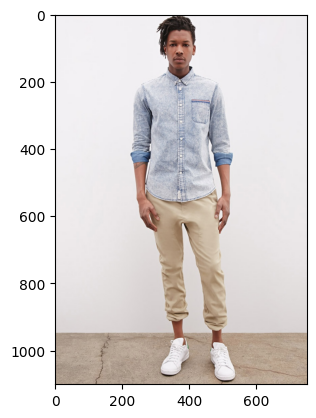

caption:  His shirt has medium sleeves, denim fabric and complicated patterns. The neckline of it is lapel. The gentleman wears a long trousers. The trousers are with cotton fabric and solid color patterns. 

generated:  The upper clothing has sleeves cut off, cotton fabric and graphic patterns. It has a suspenders neckline. The lower clothing is of three-point length. The fabric is cotton and it has pure color patterns. There is an accessory on her wrist. There is a ring on her finger. 

best score:  10.633768081665039
bleu score:  2.5990365708266216e-78
rouge-l score:  0.34482758126040436
meteor score:  0.6852470546861262


In [25]:
#  =================== Model Inference ===================
test_set = ImageTextDataset(dataset_root,
                            test_labels_path,
                            vocabulary=vocabulary,
                            max_seq_len=seq_length,
                            transform=transform)

image_path, caption = test_set.sample()
original_image = Image.open(image_path)
image = transform(original_image).unsqueeze(0)
caption_generated, score, attn_images = generate_by_beam_search(model, image, vocabulary, device, seq_length,
                                                                mask_func, beam_width=5)

plt.imshow(original_image)
plt.show()

print('caption: ', caption, '\n\ngenerated: ', caption_generated, '\n')
print('best score: ', score)  # 序列全概率的负对数似然, 越小越好
print('bleu score: ', bleu(caption_generated, caption, vocabulary))
print('rouge-l score: ', rouge_l(caption_generated, caption, vocabulary))
print('meteor score: ', meteor(caption_generated, caption, vocabulary))

### 九、可视化注意力热图

- 取最后一个解码器层的交叉注意力输出投影到原始图像尺寸可视化

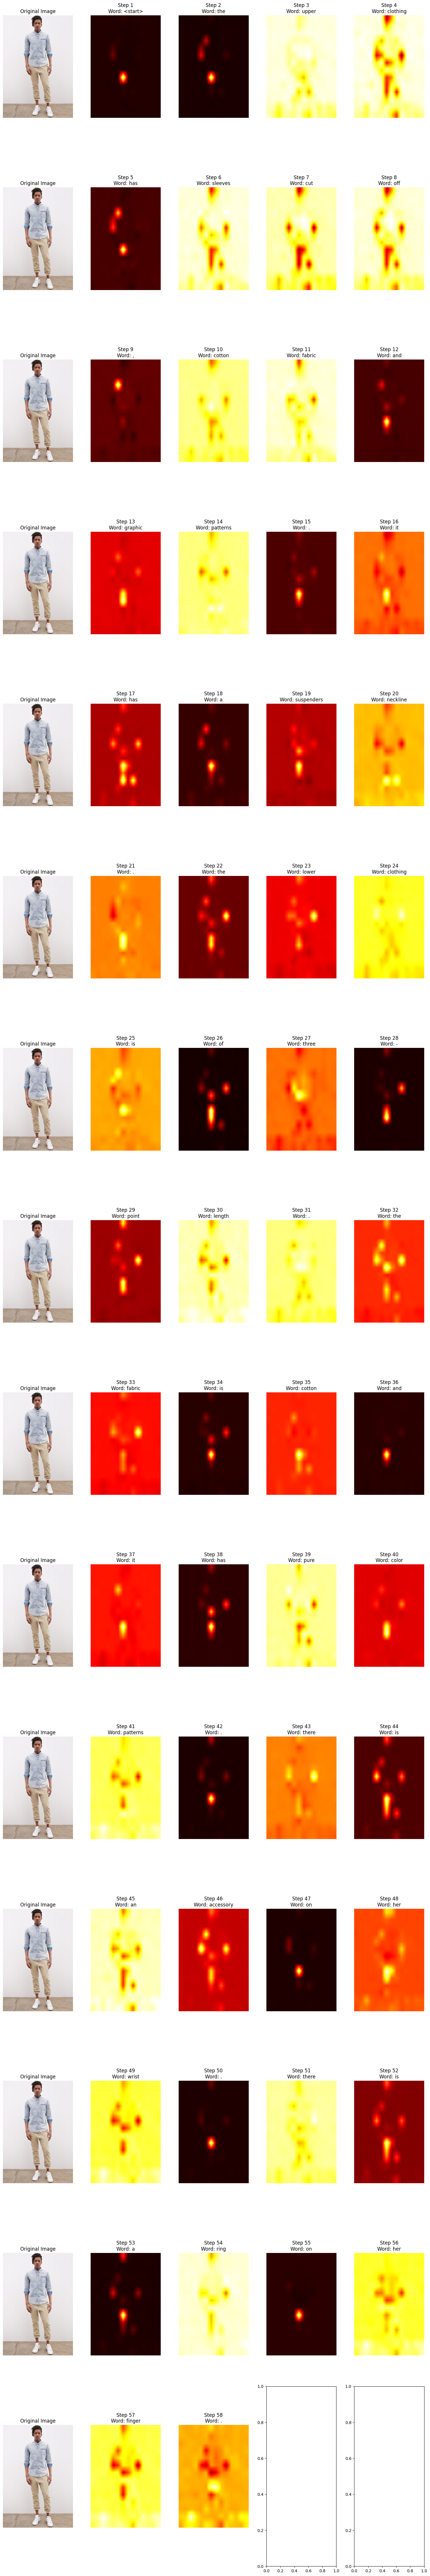

In [26]:
visualize_attention(original_image, attn_images)  # 绘制注意力图

### 十、在整个测试集上评估模型

In [14]:
evaluate(model, test_set, vocabulary, mask_func, device, seq_length, beam_width=5)  # 在测试集上评估模型

evaluating:   1%|▏         | 36/2538 [00:36<41:17,  1.01it/s, bleu=0.258, meteor=0.671, rouge_l=0.531, score=9.8] /home/hammer/Documents/PycharmProjects/FashionDescription/venv/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
evaluating:   9%|▉         | 236/2538 [04:31<44:04,  1.15s/it, bleu=0.281, meteor=0.677, rouge_l=0.542, score=10.1]  


KeyboardInterrupt: 